[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/niteshjindal170988/supervised-learning/blob/main/classification/fisher-discriminant-analysis/fisher_linear_discriminant.ipynb)


# Fischer Discriminant Analysis:
<br>
The goal is to maximise the separation between the classes. In other words, we are interested in the features that best separate the class. For every feature, compute the mean and standard deviation for every class.<br><br>

In order to maximise the separation between classes, their mean has to be as high as possible and their standard deviation should be as low as possible.<br>

Means of classes along the dimension f should be High i.e., $\left(\mu_{A, f}-\mu_{B, f}\right)^{2}$ should be High.
Variance of classes along the dimension f should be Low i.e, $n_A*\sigma_{A,f}^{2}+n_B*\sigma_{B, f}^{2}$ should be Low.<br>
where A and B are the classes, and f represents a feature. n_A and n_B are the number of data points in class A and class B, respectively. We have multiplied the n_A and n_B with variance to capture the scatter as there can be a varying number of data points in classes.




In Fischer Discrimination Analysis, we assume **(first assumption)** that classes have a unimodal distribution if one class has two peaks and is distributed at both extreme ends, while the other class is distributed somewhere in the middle. In such a case, it would be difficult to discriminate between the classes. (The **second assumption** is that if a class's distribution is not normal, we use logs or the necessary transformation to produce a normal distribution shape.<br><br>
This approach is different from the Principal Component Analysis (PCA) approach in the way that it just picks the features, i.e., the features that best separate the classes, instead of projecting the features to lower dimensional space. Both approaches are linear transformation techniques and reduces the dimensions in the data.<br><br>

**While in PCA, we can get D projections, i.e., as many dimensions are there in the data, in the Fischer Discriminant Analysis, we can get up to C-1 projections, i.e., the number of classes C minus 1.**


## FDA implementation on the Iris dataset:

## Import Packages:

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # used in q 2 for plots.
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier # for decision tree- classification case
from sklearn import metrics  # for accuracy computation
from sklearn.model_selection import train_test_split  # splitting dataset in train test data
import math  # for log functions during entropy calculations
from sklearn.preprocessing import StandardScaler # during PCA on MNIST data 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier # for question 5 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from IPython.display import display

In [4]:
%pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org gdown==4.2.0
import gdown
import warnings
warnings.filterwarnings("ignore")

url = 'https://drive.google.com/uc?id=10JjVR2tNxN0w1uHW-5iRsvXuZGKxUp92'
output = 'Iris.csv'
gdown.download(url, output, quiet=False, verify=False)


You should consider upgrading via the '/home/nitesh/env/dev37/python37/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Downloading...
From: https://drive.google.com/uc?id=10JjVR2tNxN0w1uHW-5iRsvXuZGKxUp92
To: /home/nitesh/env/dev37/repos/supervised-learning/classification/fisher-discriminant-analysis/Iris.csv
100%|██████████| 5.11k/5.11k [00:00<00:00, 4.08MB/s]


'Iris.csv'

In [5]:
'Load the iris data'
irisdata = pd.read_csv("Iris.csv")
%rm "Iris.csv"

predictors= irisdata[irisdata.columns[1:5]].values
response = irisdata['Species']
# iris
predictors_train, predictors_test, response_train, response_test=train_test_split(predictors, response, test_size=0.3, random_state=11915048)

print("predictors_train_iris shape:", predictors_train.shape)
print("predictors_test_iris shape:", predictors_test.shape)
print("response_train_iris shape:", response_train.shape)
print("response_test_iris shape:", response_test.shape)

predictors_train_iris shape: (105, 4)
predictors_test_iris shape: (45, 4)
response_train_iris shape: (105,)
response_test_iris shape: (45,)


## Scatter plot 
<br>
Visualize the distribution of class labels, viz., setosa, versicolor, virginica along each dimension.

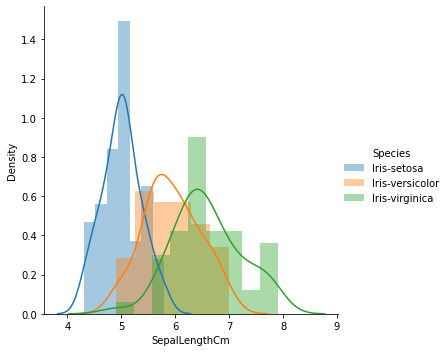

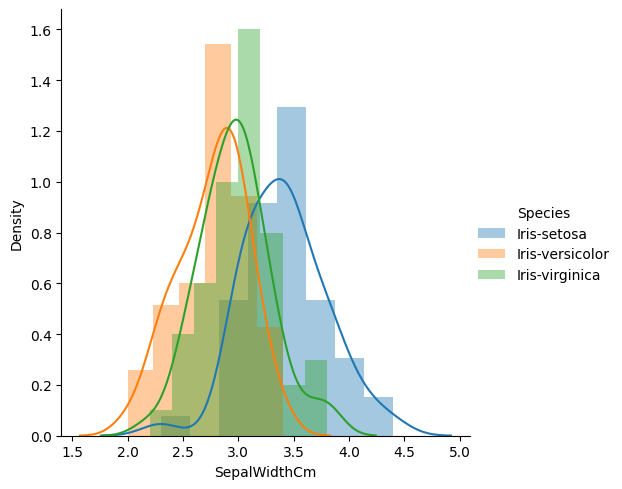

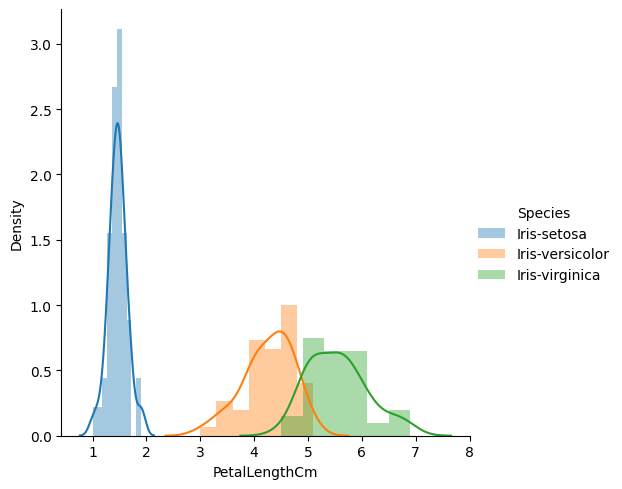

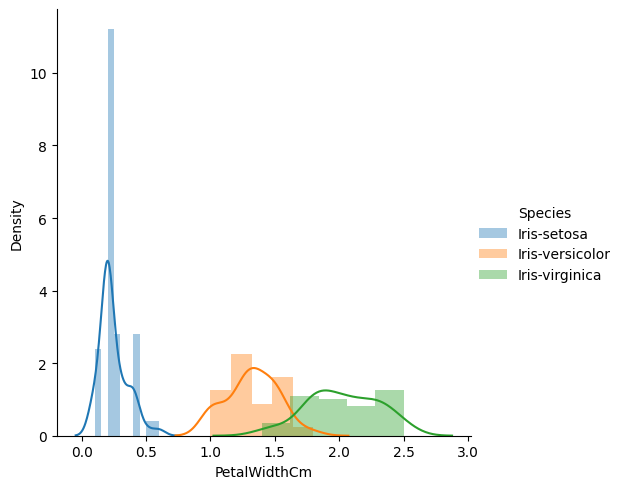

In [5]:
import warnings
warnings.filterwarnings("ignore")
sns.FacetGrid(irisdata, hue="Species", height=5).map(sns.distplot, "SepalLengthCm").add_legend()
sns.FacetGrid(irisdata, hue="Species", height=5).map(sns.distplot, "SepalWidthCm").add_legend()
sns.FacetGrid(irisdata, hue="Species", height=5).map(sns.distplot, "PetalLengthCm").add_legend()
sns.FacetGrid(irisdata, hue="Species", height=5).map(sns.distplot, "PetalWidthCm").add_legend()

plt.show()

From the above plots, it is apparent that class labels, Iris-virginica and Iris-versicolor, are more similar to each other since their distribution partially or completely overlaps over each other across all the individual dimensions, whereas class Iris-setosa's distribution discriminates against the other two classes' distributions.


## Combine Iris- virginica and Iris-versicolor classes

we will now create a metaclass by coalescing the classes Iris- virginica and Iris- versicolor into a single class and then implement Fisher projection by discriminating merged classes with the other class.

In [6]:
target_train = np.array(response_train.replace(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], [1, 2, 2]))
target_test = np.array(response_test.replace(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], [1, 2, 2]))

## Fischer Projection - 1
<br>
Create the Fisher projection by discriminating class **1** and class **2**.

#### Mean Vector

In [25]:
"mean vector corresponding to each class"
mean_vec = []
for i in tuple(set(target_train)):
    # mean vector for both classes ; axis = 0 refers to colsum
    mean_vec.append(np.mean(predictors_train[target_train == i], axis = 0))  # 'mean' value  for each of two class label.
    
print("Mean Vector of Classes:\n", mean_vec)


Mean Vector of Classes:
 [array([5.04324324, 3.45135135, 1.45675676, 0.24054054]), array([6.24264706, 2.84558824, 4.93235294, 1.68676471])]


#### Within Class Scatter Matrix 

In [9]:
"within class scatter matrices: scatter matrix corresponding to each class"

within_class_scattermatrix = np.zeros((4,4))  # we have 4 dimensions so initiaize a 4*4 matrix.

for i, mc in zip(tuple(set(target_train)), mean_vec):
    scatter_matrix = np.zeros((4,4))
    for obs in predictors_train[target_train == i]:
        obs, mc = obs.reshape(4,1), mc.reshape(4,1)
        val=(obs-mc).dot((obs-mc).T) # make column vectors
        scatter_matrix += val  # (x-mu).dot.Transpose(x-mu) to obtain the scatter matrix for each class
    within_class_scattermatrix += scatter_matrix      # sum class scatter matrices
    #within class scatter matrix has total variance which is sum of variance from each class.
print("within class scatter matrix:\n",within_class_scattermatrix)


within class scatter matrix:
 [[36.77713434 13.49563196 36.33536566 13.57351749]
 [13.49563196 13.1411089  13.02186804  7.22400238]
 [36.33536566 13.02186804 55.79963434 23.15398251]
 [13.57351749  7.22400238 23.15398251 14.16727742]]


#### Between Class Scatter Matrix 
<br>
Take mean of datapoints in each class i.e., sum of the means of both the classes. 

In [10]:
overall_mean = np.mean(predictors_train, axis=0)

#initialise 4*4 dimensional scatter matrix with zeros-
between_class_scattermatrix = np.zeros((4,4))
for i, m in enumerate(mean_vec,0): 
    # sample size for each class. It will be multiplied while calc between class scatter matrix.
    sample_size = predictors_train[target_train==i+1,:].shape[0]   
    m = m.reshape(4,1) # make column vector of mean vector with shape (4,1)
    overall_mean = overall_mean.reshape(4,1) # make column vector of mean of entire data with shape (4,1)
    between_class_scattermatrix += sample_size * (m - overall_mean).dot((m- overall_mean).T)
print("\n")
print("Between class scatter matrix:\n", between_class_scattermatrix)



Between class scatter matrix:
 [[ 34.47086566 -17.40963196  99.88863434  41.56448251]
 [-17.40963196   8.79279586 -50.44910614 -20.9922881 ]
 [ 99.88863434 -50.44910614 289.45427042 120.4443032 ]
 [ 41.56448251 -20.9922881  120.4443032   50.11786543]]


#### Compute Eigen Vectors and Eigen Values

In [14]:
"Compute Eigen values & Eigen vectors"
#Fisher projection = (S^-1 * B) which is 4*4 matrix.
eigenval, eigenvect = np.linalg.eig(np.linalg.inv(within_class_scattermatrix).dot(between_class_scattermatrix)) 
#Each eigen vector has corresponding eigen value
for i in range(len(eigenval)):
    ev = eigenvect[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, ev))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eigenval[i]))
    
"Sort Eigen value and eigen vector after making their pair"
# eigen value and eigen vector pair - 
ep = [(np.abs(eigenval[i]), eigenvect[:,i]) for i in range(len(eigenval))]
# sort eigen values( eigen values with their respective eigen vector) in descending order -
ep1 = sorted(ep, key=lambda l: l[0], reverse=True)
print("Sorted Eigenvalue and Eigenvector pairs: \n")
print(ep1)


Eigenvector 1: 
[[-0.91453855]
 [-0.32543738]
 [ 0.21140209]
 [ 0.1141004 ]]
Eigenvalue 1: 0.00e+00

Eigenvector 2: 
[[-0.1332431 ]
 [-0.79737103]
 [ 0.51796724]
 [ 0.27956332]]
Eigenvalue 2: 1.04e+01

Eigenvector 3: 
[[-0.39391244]
 [ 0.41169416]
 [ 0.48403515]
 [-0.66411662]]
Eigenvalue 3: 5.36e-15

Eigenvector 4: 
[[-0.32473468]
 [ 0.89757043]
 [ 0.29253737]
 [-0.0577633 ]]
Eigenvalue 4: 1.31e-15
Sorted Eigenvalue and Eigenvector pairs: 

[(10.447127379301534, array([-0.1332431 , -0.79737103,  0.51796724,  0.27956332])), (5.361821647744845e-15, array([-0.39391244,  0.41169416,  0.48403515, -0.66411662])), (1.3101199696770006e-15, array([-0.32473468,  0.89757043,  0.29253737, -0.0577633 ])), (0.0, array([-0.91453855, -0.32543738,  0.21140209,  0.1141004 ]))]


Eigen vector with the lowest corresponding eigen value is having minimal information about the distribution. Extract the first eigen vector and value that captures maximum information and best separate the two classes.


#### Top two eigen vectors and project the test data on these vectors

In [18]:
top_2_eigenvect = np.hstack((ep1[0][1].reshape(4,1), ep1[1][1].reshape(4,1)))  
print("Top two projection: \n", top_2_eigenvect) 

lda_data = predictors_test.dot(top_2_eigenvect) # choose predictors_test_iris which is test features set.
print("\n")

colnames = []
for i in range(0,2):
    colnames.append("projection" + str(i))
    
lda_iris  = pd.DataFrame(data = lda_data, columns = colnames, dtype = None)
lda_iris['target'] = target_test  # append label column to projected data frame
print("projected data in two dimensions(LDA1 and LDA2):\n")
print(lda_iris)


Top two projection: 
 [[-0.1332431  -0.39391244]
 [-0.79737103  0.41169416]
 [ 0.51796724  0.48403515]
 [ 0.27956332 -0.66411662]]


projected data in two dimensions(LDA1 and LDA2):

    projection0  projection1  target
0     -1.676321    -0.395699       1
1     -2.465968     0.150613       1
2     -2.293170     0.107666       1
3      0.100048     0.143730       2
4     -0.658454    -0.094764       2
5     -0.361637     0.012422       2
6     -0.016121    -0.165700       2
7     -0.589009     0.089321       2
8     -0.411997    -0.019465       2
9      0.384511    -0.372897       2
10    -0.370732    -0.069647       2
11    -0.510788    -0.084171       2
12    -0.007121    -0.222599       2
13     0.247091     0.033640       2
14    -2.383439     0.050250       1
15     0.430261    -0.118756       2
16    -0.163643     0.008579       2
17     0.048920    -0.193712       2
18    -0.097150     0.043825       2
19    -0.433843    -0.066147       2
20    -0.505027     0.028635       2
21 

#### Plot the two projections in 2D space

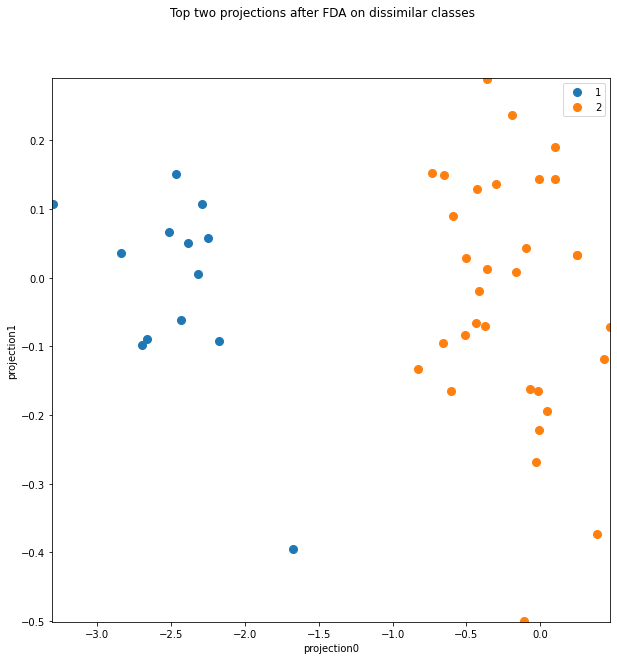

In [20]:
lbl_grp = lda_iris.groupby('target')
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('Top two projections after FDA on dissimilar classes')
plt.xlabel('projection0')
plt.ylabel('projection1')
ax.margins(0.001) # Optional, just adds 5% padding to the autoscaling
for name, group in lbl_grp:
    ax.plot(group.projection0, group.projection1, marker='o', linestyle='', ms=8, label=name)
ax.legend()

plt.show()

## Combine Iris- virginica and Iris-versicolor classes
we will now create a metaclass by coalescing the classes Iris- virginica and Iris- versicolor into a single class and then implement Fisher projection by discriminating merged classes with the other class.

In [110]:
iris_nw=irisdata[(irisdata["Species"] == "Iris-virginica") |
                        (irisdata["Species"] == "Iris-versicolor")]
iris_nw['Species']= iris_nw['Species'].map({'Iris-versicolor':1, 'Iris-virginica':2 })
# iris_nw = iris_nw[iris_nw.Species.replace(['Iris-versicolor', 'Iris-virginica'], [1, 2])]
#df[(df['alcohol'] > 14.3) & (df['hue'] > 1.0)]
predictors= iris_nw[iris_nw.columns[1:5]].values
response = iris_nw['Species']
predictors_train, predictors_test, response_train, response_test=train_test_split(predictors, response, test_size=0.3, random_state=11915048)

print("predictors_train_iris shape:", predictors_train.shape)
print("predictors_test_iris shape:", predictors_test.shape)
print("response_train_iris shape:", response_train.shape)
print("response_test_iris shape:", response_test.shape)

classval=np.array(response_train)
classval

predictors_train_iris shape: (70, 4)
predictors_test_iris shape: (30, 4)
response_train_iris shape: (70,)
response_test_iris shape: (30,)


#### Mean Vector

In [120]:
np.set_printoptions(precision=2, suppress = False)

mean_class = []
for i in range(1,3):
    # mean vector for both the different classes ; axis = 0 refers to colsum
    mean_class.append(np.mean(predictors_train[classval == i], axis = 0))  # 'mean' value  for each of two class label.
    
print("Mean of both the classes:\n",mean_class)
print("\n")

Mean of both the classes:
 [array([5.96, 2.79, 4.23, 1.32]), array([6.69, 2.97, 5.58, 2.  ])]




#### Within class scatter matrix

In [131]:
within_class_scattermatrix = np.zeros((4,4))  # since we have 4 dimensions

for i, mc in zip(range(1,3), mean_class):                       # range(1,3) since we have two classes i.e. 1, 2.
    scatter= np.zeros((4,4))                  # scatter matrix for every class
    for obs in predictors_train[classval == i]:
        obs, mc = obs.reshape(4,1), mc.reshape(4,1)             # make column vectors
        scatter += (obs-mc).dot((obs-mc).T)   # (x-mu).dot.Transpose(x-mu) to obtain the scatter matrix for each class
    within_class_scattermatrix += scatter    # sum class scatter matrices
    #within class scatter matrix has total variance which is sum of variance from each class.
print("within class scatter matrix:\n",within_class_scattermatrix)


within class scatter matrix:
 [[24.65  6.58 18.84  4.04]
 [ 6.58  6.81  5.17  2.5 ]
 [18.84  5.17 19.89  3.83]
 [ 4.04  2.5   3.83  3.61]]


#### Between class scatter matrix

In [132]:
#mean of datapoints in each class - mean of entire data 
#mean of entire datapoints comprising class 1 datapoints and class2 datapoints. We can call it as mean of entire data -
overall_mean = np.mean(predictors_train, axis=0)

#initialise 4*4 dimensional scatter matrix with zeros-
between_class_scattermatrix = np.zeros((4,4))

#In below code, list(enumerate(mean_class,0)) = [(0, array([5.01, 3.42, 1.46, 0.24])), (1, array([6.26, 2.87, 4.91, 1.68]))]
# mean_ class is list of 'mean of datapoints' belonging to classes 1 and 2 in a 4 dimensional space.

for i,classmean in enumerate(mean_class,0): 
    # sample size for each class. It will be multiplied while calc between class scatter matrix.
    sample_size = predictors_train[classval==i+1,:].shape[0]   
    classmean = classmean.reshape(4,1) # make column vector of mean vector with shape (4,1)
    overall_mean = overall_mean.reshape(4,1) # make column vector of mean of entire data with shape (4,1)
    between_class_scattermatrix += sample_size * (classmean - overall_mean).dot((classmean - overall_mean).T)
print("\n")
print("between class scatter matrix:\n",between_class_scattermatrix)




between class scatter matrix:
 [[ 9.31  2.35 17.25  8.65]
 [ 2.35  0.6   4.36  2.19]
 [17.25  4.36 31.94 16.01]
 [ 8.65  2.19 16.01  8.03]]


#### Computer fischer projection: eigen value and eigen vector 

In [133]:
"Compute Eigen values & Eigen vectors"
np.set_printoptions(precision=2, suppress = False)
#Fisher projection = (S^-1 * B) which is 4*4 matrix.
eigenval, eigenvect = np.linalg.eig(np.linalg.inv(within_class_scattermatrix).dot(between_class_scattermatrix)) 

#Eigen value has shape (4,1) and eigen vector has shape (4,4). Each eigen vector has corresponding eigen value

for i in range(len(eigenval)):
    ev = eigenvect[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, ev))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eigenval[i]))
    


Eigenvector 1: 
[[-0.86+0.j]
 [-0.13+0.j]
 [ 0.27+0.j]
 [ 0.42+0.j]]
Eigenvalue 1: 0.00e+00+0.00e+00j

Eigenvector 2: 
[[-0.32+0.j]
 [-0.24+0.j]
 [ 0.5 +0.j]
 [ 0.77+0.j]]
Eigenvalue 2: 3.89e+00+0.00e+00j

Eigenvector 3: 
[[-0.  +0.04j]
 [ 0.92+0.j  ]
 [-0.13+0.15j]
 [ 0.01-0.34j]]
Eigenvalue 3: 3.78e-16+3.05e-16j

Eigenvector 4: 
[[-0.  -0.04j]
 [ 0.92-0.j  ]
 [-0.13-0.15j]
 [ 0.01+0.34j]]
Eigenvalue 4: 3.78e-16-3.05e-16j


#### Sort eigen values and get the top two projections

In [156]:

"Sort Eigen value and eigen vector after making their pair"

# eigen value and eigen vector pair - 
ep = [(np.abs(eigenval[i]), eigenvect[:,i]) for i in range(len(eigenval))]
print("Eigenvalue and Eigenvector pairs: \n")
print(ep)
print("\n")

# sort eigen values( eigen values with their respective eigen vector) in descending order -
ep1 = sorted(ep, key=lambda l: l[0], reverse=True)
print("Sorted Eigenvalue and Eigenvector pairs: \n")
print(ep1)

"""Eigen vector with the lowest corresponding eigen value is having minimal information about the distribution.
Therefore, we should drop such eigen vector. 
To do so, we should make eigen value-eigen vector pair and sort them in descending order of eigen values. 
Then, we shall take out first eigen vectors with their corresponding eigen values"""



"four*two dimensional eigen vector matrix which we can say as top two projections"
print("\n")
top_2_eigenvect = np.hstack((abs(ep1[0][1]).reshape(4,1), abs(ep1[1][1]).reshape(4,1)))
print("Top two projection: \n")
print(top_2_eigenvect) 


Eigenvalue and Eigenvector pairs: 

[(0.0, array([-0.86+0.j, -0.13+0.j,  0.27+0.j,  0.42+0.j])), (3.8924168170749622, array([-0.32+0.j, -0.24+0.j,  0.5 +0.j,  0.77+0.j])), (4.855269156149336e-16, array([-0.  +0.04j,  0.92+0.j  , -0.13+0.15j,  0.01-0.34j])), (4.855269156149336e-16, array([-0.  -0.04j,  0.92-0.j  , -0.13-0.15j,  0.01+0.34j]))]


Sorted Eigenvalue and Eigenvector pairs: 

[(3.8924168170749622, array([-0.32+0.j, -0.24+0.j,  0.5 +0.j,  0.77+0.j])), (4.855269156149336e-16, array([-0.  +0.04j,  0.92+0.j  , -0.13+0.15j,  0.01-0.34j])), (4.855269156149336e-16, array([-0.  -0.04j,  0.92-0.j  , -0.13-0.15j,  0.01+0.34j])), (0.0, array([-0.86+0.j, -0.13+0.j,  0.27+0.j,  0.42+0.j]))]


Top two projection: 

[[0.32 0.04]
 [0.24 0.92]
 [0.5  0.2 ]
 [0.77 0.34]]


#### Apply fischer projections on the test data 

In [157]:
lda_1=predictors_test.dot(top_2_eigenvect)
colnames = []
for i in range(0,2):
    colnames.append("projection" + str(i))
lda_iris  = pd.DataFrame(data = lda_1, columns = colnames, dtype = None)
lda_iris['classlabel'] = np.array(response_test)
lda_iris

,projection0,projection1,classlabel
0,7.721855,5.346783,2
1,7.204881,4.710954,2
2,6.508440,4.391101,2
3,7.655021,5.189084,2
4,6.499752,4.606059,2
5,5.614096,4.187166,1
6,6.445337,4.468897,2
7,7.549901,4.950372,2
8,5.739673,4.154419,1
9,6.341877,4.297056,1


#### Plot the Projections

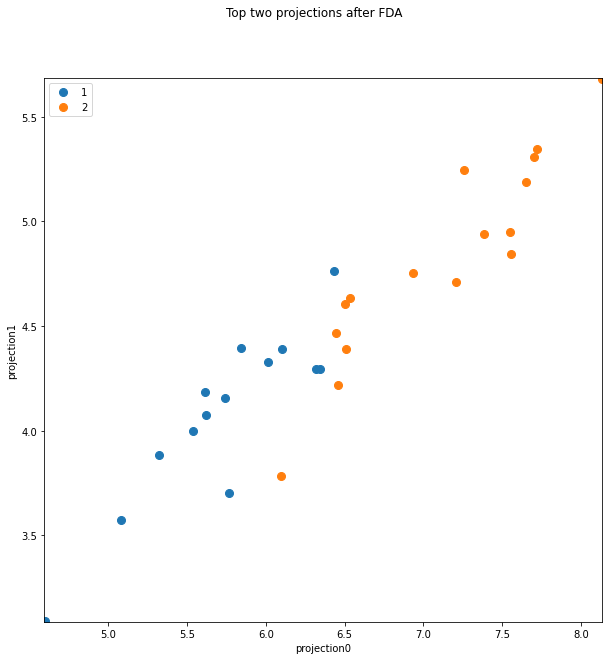

In [158]:
"plot the projected data and label the two classes"
grpbylabel = lda_iris.groupby('classlabel')
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('Top two projections after FDA')
plt.xlabel('projection0')
plt.ylabel('projection1')
ax.margins(0.001) # Optional, just adds 5% padding to the autoscaling
for name, group in grpbylabel:
    ax.plot(group.projection0, group.projection1, marker='o', linestyle='', ms=8, label=name)
ax.legend()

plt.show()



After looking at the plots above from both cases, we observe that when we choose 'iris-Versicolor' and 'iris-Virginica' classes, the projection plots are overlapping and class separation is difficult, whereas the class separation is perfectly evident when we choose two dissimilar classes. 